## C. difficile Microbiome Analysis Pipeline
***16S Amplicon Sequencing Analysis***  

___William Sano___
___FISH546 - Dr. Stephen Roberts F18___  


Re-analysis of data from BioProject PRJNA412501, a study on the dynamics of gut microbial communities in _Clostridium difficile_-infected individuals treated by fecal matter transplant (FMT).

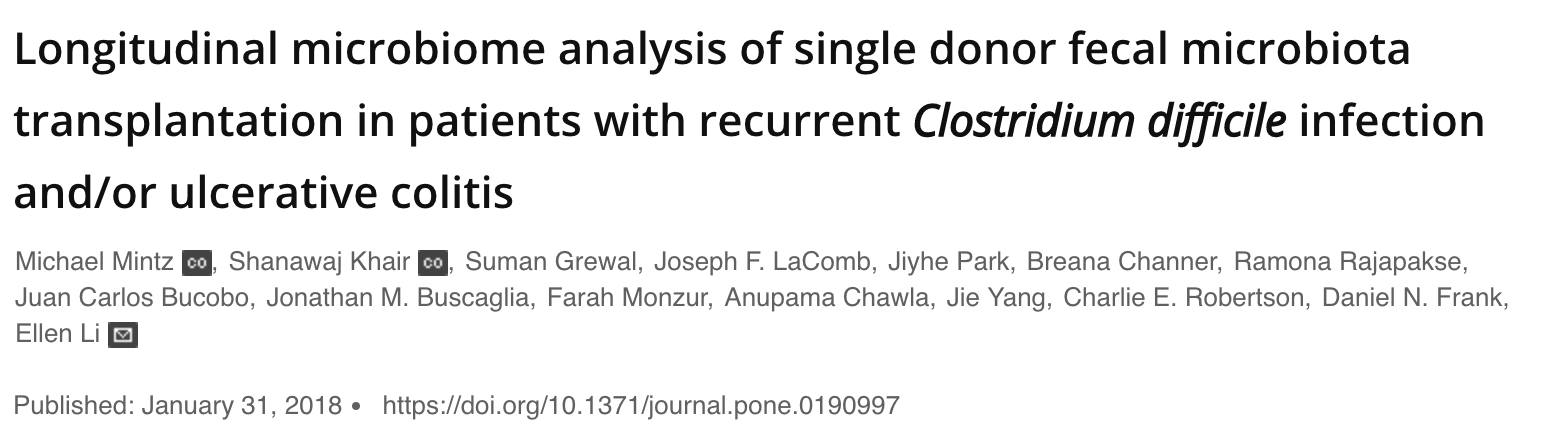

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5791968/

## Background Information
_C. difficile_ is present in the healthy gut microbiome as a commensal, but disturbance of the gut microbiome by antibiotic treatment can allow this opportunistic pathogen to bloom, causing severe diarrhea and dehydration. There are about 500,000 cases of CDI in the US every year, which lead to about 15,0000 deaths. The majority of the cases are nosocomial infections, meaning they were aquired in a hospital by patients being treated for other conditions (often via antibiotic therapy). CDI is famously difficult to treat, since the conventional treatment, antibiotics, also drives _C. difficile_ blooms. About 25% of patients treated for _C. difficile_ experience recurrent infections, leading to further morbidity and mortality.

A promising alternative therapy to antibiotics for CDI may be fecal matter transplants (FMT). Healthy donors can provide fecal samples, which can be delivered straight to a patient's GI tract. The thinking here is that the FMT nudges the recipient's gut microbiome out of a dysbiotic equilibrium and towards a healthy steady state that is resilient to reinfection by _C. difficile_.

FMT is also being evaluated as a treatment option for patients with ulcerative colitis (UC), an inflammatory bowel disease. The data used here, from PRJNA412501, is 16s amplicon data from FMT donors and patients (CDI+, UC+, and UC/CDI+) pre-FMT and then at two timepoints post-treatment.

# Question: How does FMT affect the fecal microbiome of individuals with _Clostridium difficile_ infections and/or ulcerative colitis?

# Workflow visualization [here](url)

##  Data Importing
### Make sure that you have initialized a Qiime2 (ver. 2018.8) environment in conda. Instructions [here](https://docs.qiime2.org/2018.8/tutorials/filtering/)

16s data from FMT donors and patients (CDI+, UC+, and UC/CDI+) preFMT, 1 week postFMT, and 3 months postFMT) downloaded from published study, BioProject:PRJNA412501, downloaded with the ENA downloader software v1.2.2 to `data/FMT/raw`

**Sequence data downloaded from the ENA 11.27.18, 2:22pm**  



In [ ]:
%%bash
java -jar /*path_to_ena_downloader*/ena-file-downloader-v1.2.2.jar

In [ ]:
%%bash
SRRlist=$(find data/raw -name "*.fastq.gz" | xargs -n 1 basename | cut -d '.' -f 1 | sort | uniq)
echo $SRRlist

gunzip data/raw/* -k

echo -e "sample-id,absolute-filepath,direction" > scripts/FMT_manifest.csv

for file in ${SRRlist[@]}
do

#uncomment for paired end sequences
#for_link=$(greadlink -f "data/raw/"$file"_1.fastq")
#rev_link=$(greadlink -f "data/raw/"$file"_2.fastq")
#echo -e "$file,$for_link,forward" >> scripts/FMT_manifest.csv
#echo -e "$file,$rev_link,reverse" >> scripts/FMT_manifest.csv

#uncomment for single end sequences
link=$(greadlink -f "data/raw/"$file".fastq")
echo -e "$file,$link,forward" >> scripts/FMT_manifest.csv

done
head -n 10 scripts/FMT_manifest.csv

### Importing `.fastq` files into Qiime2 environment via fastq manifest format
Phred score is 33  

In [ ]:
%%bash
df -h
export TMPDIR=/

In [ ]:
#!qiime tools import --type 'SampleData[PairedEndSequencesWithQuality]' --input-path scripts/FMT_manifest.csv --output-path data/demux.qza --input-format PairedEndFastqManifestPhred33
!qiime tools import --type 'SampleData[SequencesWithQuality]' --input-path scripts/FMT_manifest.csv --output-path data/demux.qza --input-format SingleEndFastqManifestPhred33

## Sequence Pre-processing
### Running fastqc FastQC v0.11.8 on all fastq files

In [ ]:
!mkdir analyses/fastqc
!/Applications/bioinformatics/FastQC/fastqc data/raw/*.fastq -o analyses/fastqc
!rm analyses/fastqc/*.zip

In [ ]:
!qiime demux summarize --i-data data/demux.qza --o-visualization data/demux.qzv --verbose

 Based on readout from `demux.qzv` file and fastqc, trimming forward and reverse reads at pos 20 (from left) and 200 (from right) with DADA2. This step also completes denoising and chimera checking by consensus method.
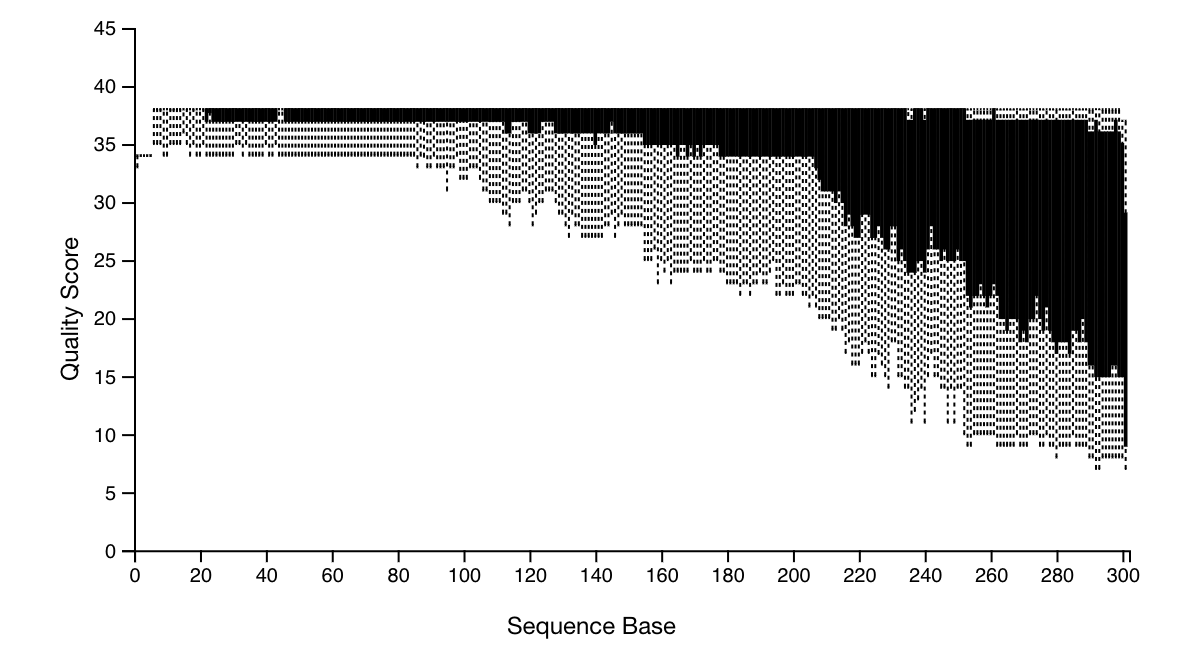

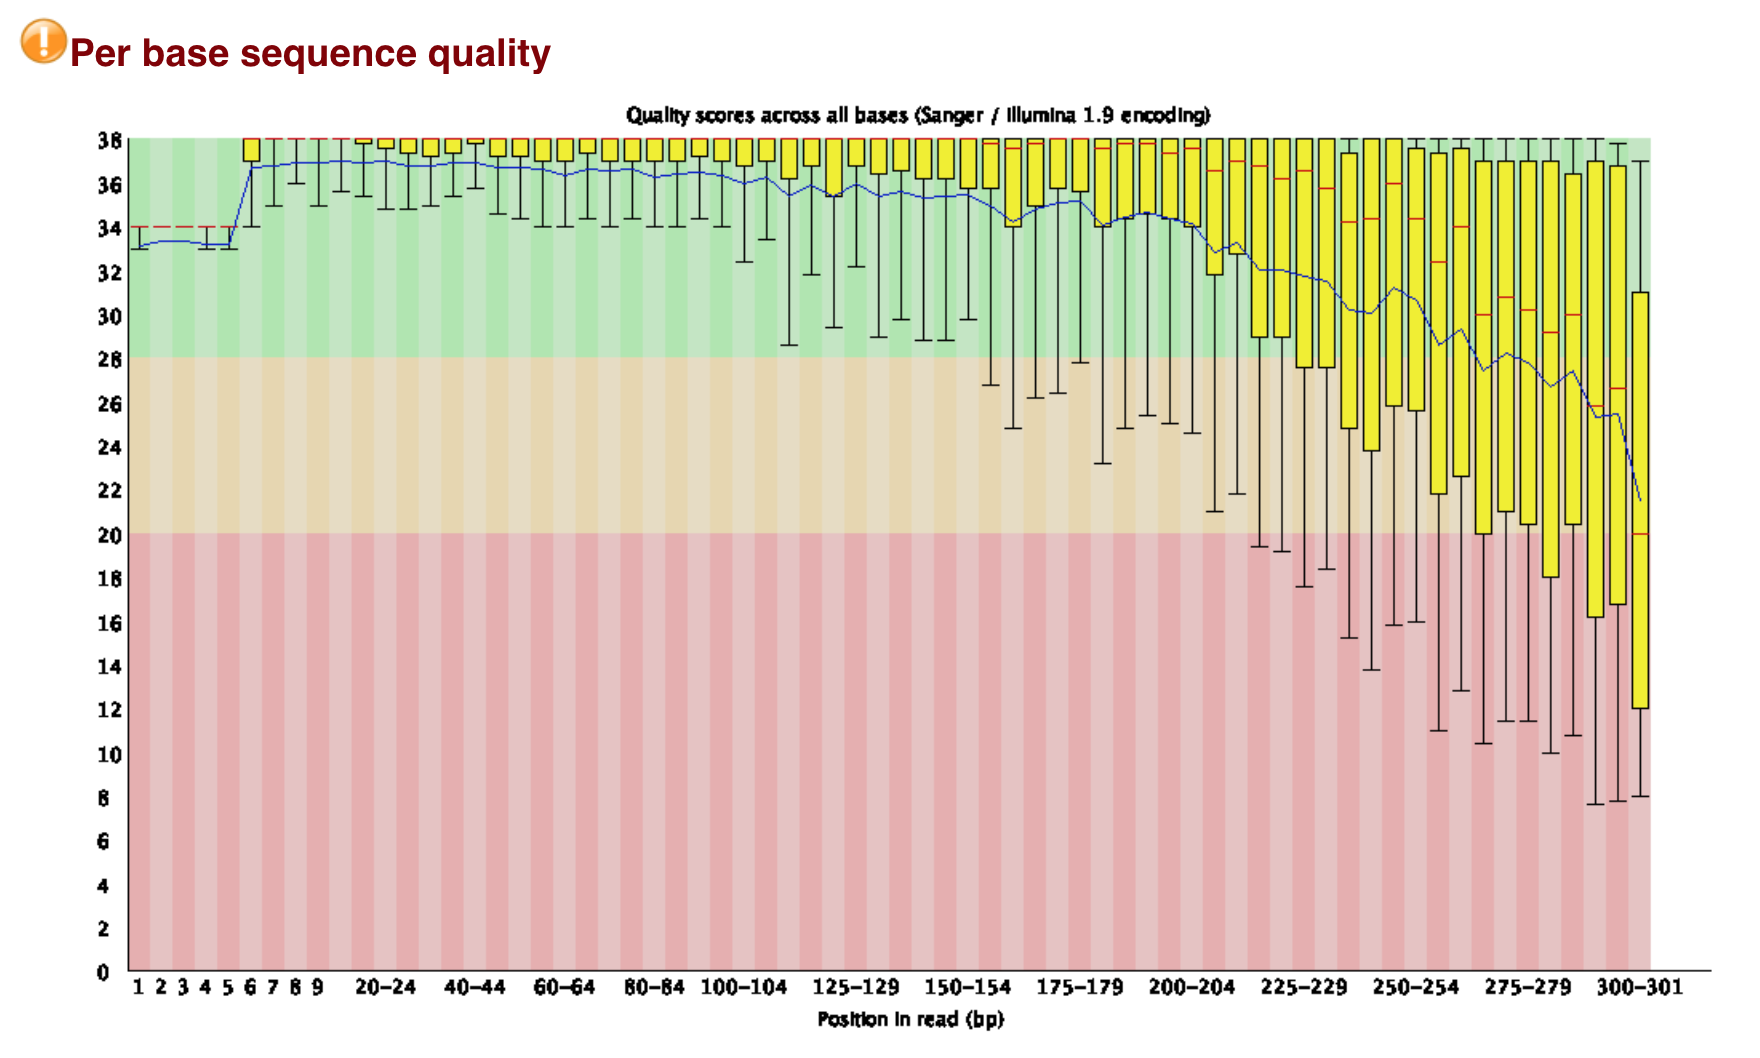

## Compiling reads into OTU/ASV table
ASV (amplicon sequence variant) is a term for OTUs generated by DADA2, because DADA2 does not attempt to match reads against a reference but against other reads in the dataset. This _de novo_ approach means that ASVs are resolved down to the single-nucleotide level vs. just 97-99% similarity. 

In [ ]:
#denoising in DADA2
!qiime dada2 denoise-single \
  --i-demultiplexed-seqs data/demux.qza \
  --o-table data/table.qza \
  --o-representative-sequences data/rep-seqs.qza \
  --o-denoising-stats data/denoising-stats.qza \
  --p-trim-left 20 \
  --p-trunc-len 200 \
  --verbose

## Make summary outputs  

Creating `.qzv` files for each `.qza` visualization allows me to examine the # of sequences assigned to each sample and the different filtering steps of DADA2, specifically how many reads were lost to quality filtering, denoising, and chimera checking.

##  ASV table summary, representative sequences, and denoising stats

In [ ]:
!qiime feature-table summarize \
  --i-table data/table.qza \
  --o-visualization data/table.qzv \
  --m-sample-metadata-file scripts/mapping.txt

!qiime feature-table tabulate-seqs \
  --i-data data/rep-seqs.qza \
  --o-visualization data/rep-seqs.qzv

!qiime metadata tabulate \
  --m-input-file data/denoising-stats.qza \
  --o-visualization data/denoising-stats.qzv

> ### output: `table.qzv`
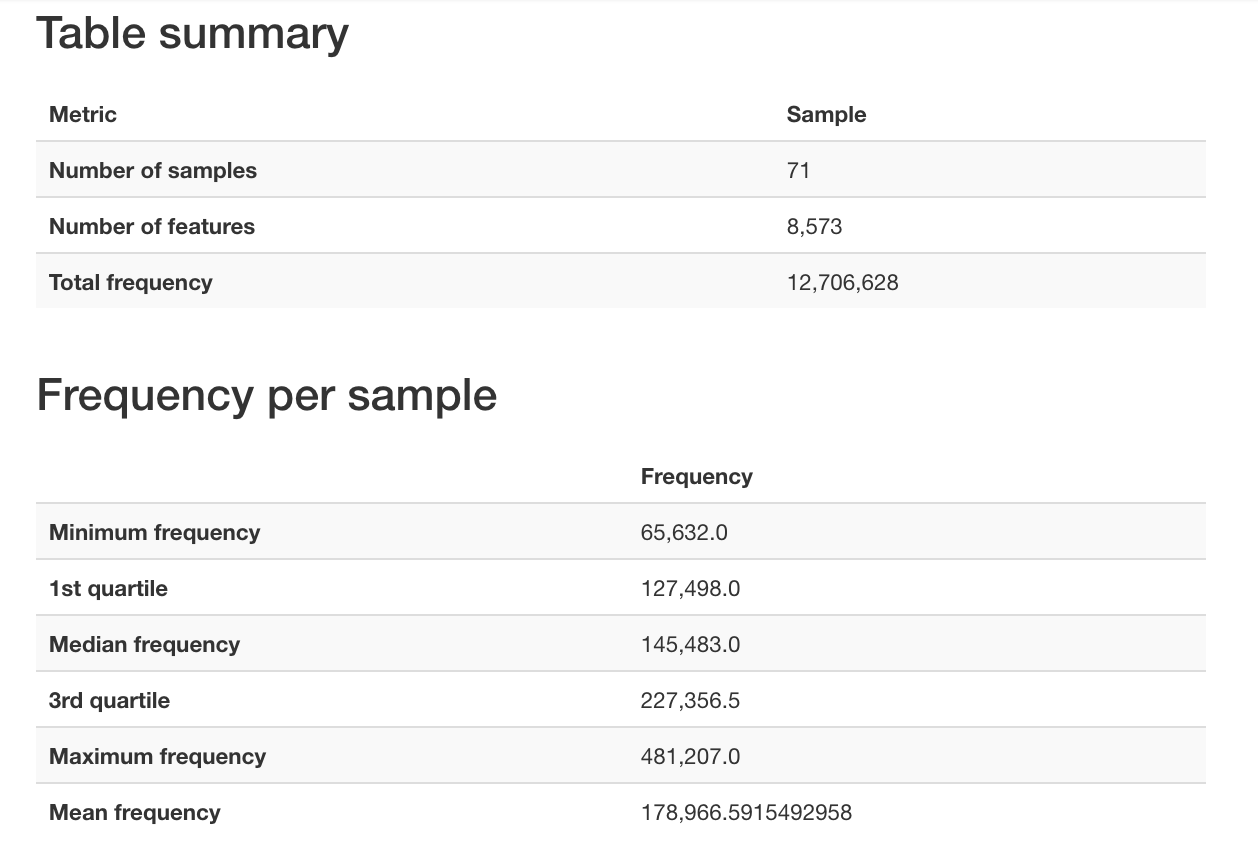

> ### output: `denoising-stats.qzv`
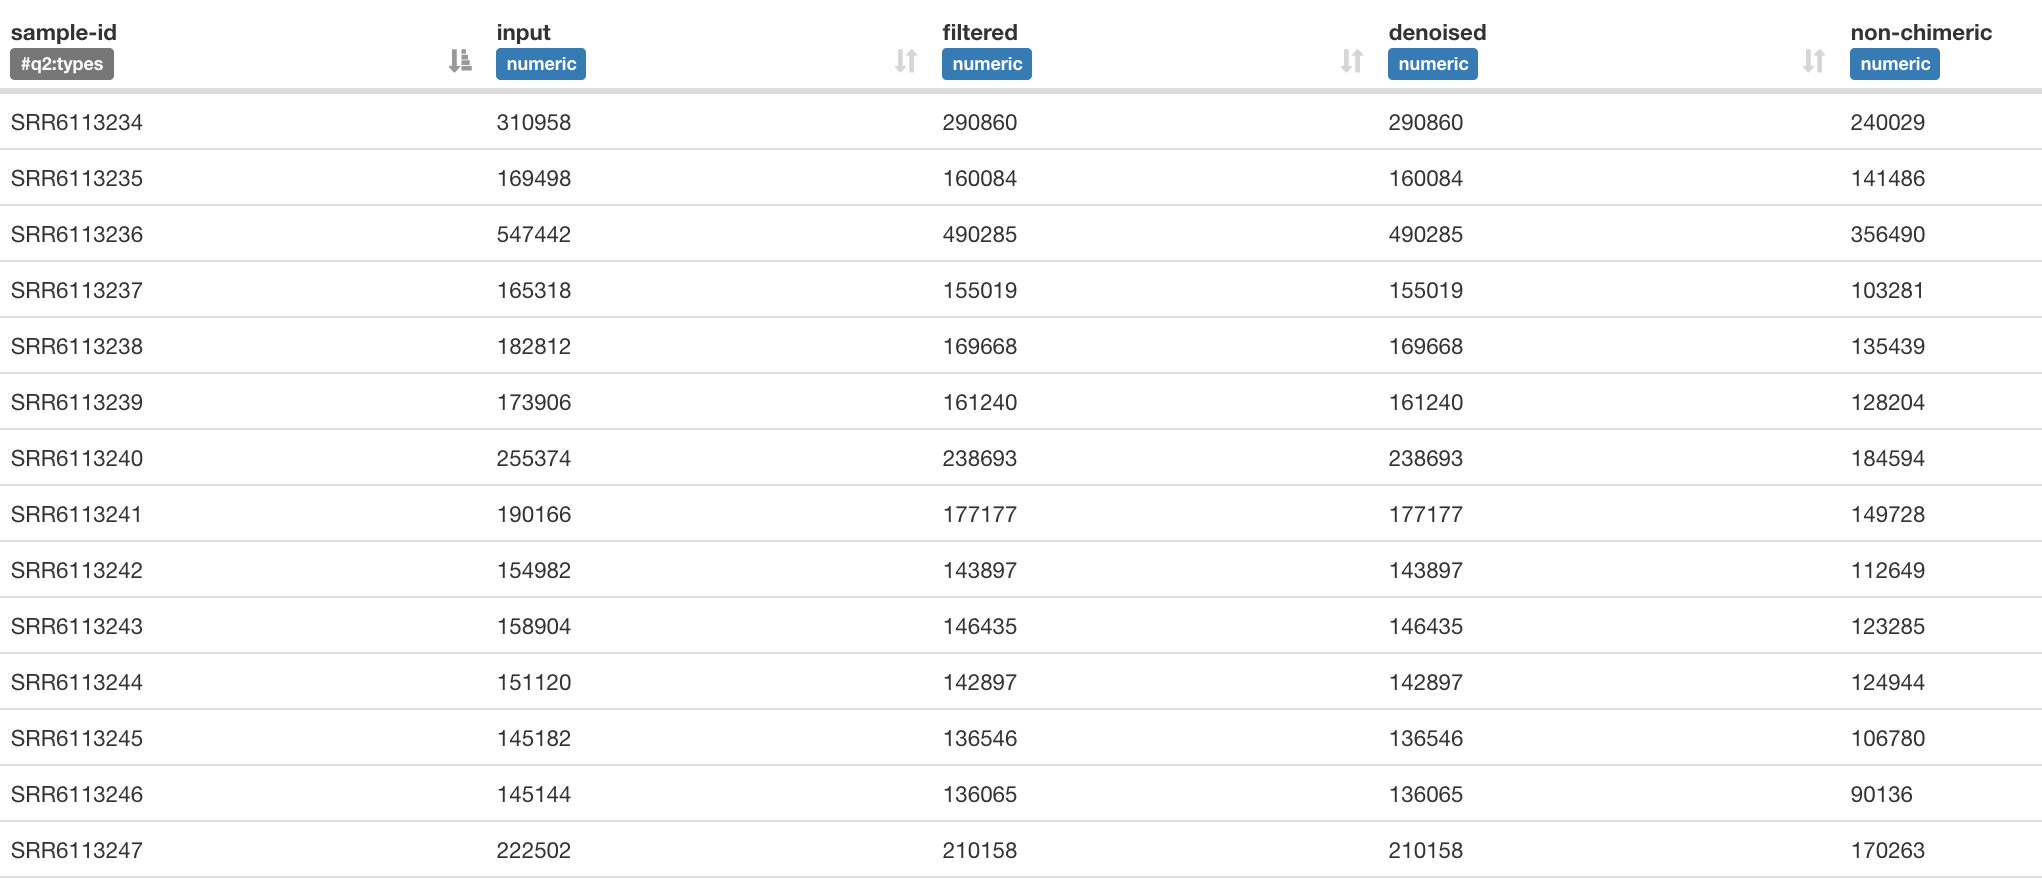

## Retrieving SILVA 99% identity OTU naive Bayes classifier for the bacterial 16S gene

This is a reference file containing 99% identity sequences for the bacterial 16S gene, which I can align my dereplicated sequence files `rep-seqs.qza` against to get the taxonomy of each feature in my ASV table 

In [ ]:
#!wget -O "silva-132-99-nb-classifier.qza" \
#"https://data.qiime2.org/2018.8/common/silva-132-99-nb-classifier.qza" \
#> data/silva-132-99-nb-classifier.qza

## Creating feature classifier to assign each of the ASVs in `rep-seqs.qza` to an OTU in SILVA database.

In [29]:
!echo $TMPDIR
!qiime feature-classifier classify-sklearn \
  --i-classifier data/silva-132-99-nb-classifier.qza \
  --i-reads data/rep-seqs.qza \
  --o-classification analyses/silva-taxonomy.qza \
  --verbose

/
^C
Traceback (most recent call last):
  File "/anaconda3/envs/qiime2-2018.8/bin/qiime", line 7, in <module>
    from q2cli.__main__ import qiime
  File "/anaconda3/envs/qiime2-2018.8/lib/python3.5/site-packages/q2cli/__init__.py", line 10, in <module>
    from ._version import get_versions
  File "/anaconda3/envs/qiime2-2018.8/lib/python3.5/site-packages/q2cli/_version.py", line 7, in <module>
    import json
  File "/anaconda3/envs/qiime2-2018.8/lib/python3.5/json/__init__.py", line 106, in <module>
    from .decoder import JSONDecoder, JSONDecodeError
  File "<frozen importlib._bootstrap>", line 968, in _find_and_load
  File "<frozen importlib._bootstrap>", line 957, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 673, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 693, in exec_module
  File "<frozen importlib._bootstrap_external>", line 782, in get_code
  File "<frozen importlib._bootstrap_external>", line 850, in get_data
KeyboardI

In [ ]:
!qiime metadata tabulate \
  --m-input-file analyses/silva-taxonomy.qza \
  --o-visualization analyses/silva-taxonomy.qzv \
  --verbose

In [ ]:
!echo $TMPDIR

## Filter out chloroplast, mitochondrial contamination from `table.qza`

In [ ]:
!qiime taxa filter-table \
  --i-table data/table.qza \
  --i-taxonomy analyses/silva-taxonomy.qza  \
  --p-exclude mitochondria,chloroplast,eukaryota,archaea \
  --o-filtered-table data/table-excl-mitochloro.qza

!qiime feature-table summarize \
  --i-table data/table-excl-mitochloro.qza \
  --o-visualization data/table-excl-mitochloro.qzv \
  --m-sample-metadata-file scripts/mapping.txt \
  --verbose

## Make tree for phylogeny-aware diversity analyses

In [ ]:
!qiime alignment mafft \
  --i-sequences data/rep-seqs.qza \
  --o-alignment data/aligned-rep-seqs.qza \
  --verbose

!qiime alignment mask \
  --i-alignment data/aligned-rep-seqs.qza \
  --o-masked-alignment data/masked-aligned-rep-seqs.qza \
  --verbose

!qiime phylogeny fasttree \
  --i-alignment data/masked-aligned-rep-seqs.qza \
  --o-tree data/unrooted-tree.qza \
  --verbose

!qiime phylogeny midpoint-root \
  --i-tree data/unrooted-tree.qza \
  --o-rooted-tree data/rooted-tree.qza \
  --verbose

## Phylogenetic Analyses

Sampling depth of 43804 for `core-metrics-phylogenetic` sequence rarefaction set by picking lowest sequence number per sample as shown in `table-excl-mitochloro.qzv`. 

In [ ]:
!qiime diversity core-metrics-phylogenetic \
  --i-phylogeny data/rooted-tree.qza \
  --i-table data/table-excl-mitochloro.qza \
  --p-sampling-depth 43804 \
  --output-dir analyses/excl-mitochloro-corediv-43804 \
  --m-metadata-file scripts/mapping.txt \
  --verbose

In [ ]:
!qiime taxa barplot \
    --i-table data/table-excl-mitochloro.qza \
    --i-taxonomy analyses/silva-taxonomy.qza \
    --m-metadata-file scripts/mapping.txt \
    --o-visualization analyses/barplot.qzv \
    --verbose

  ###  Collapsing sample by metadata-category "Group" to make a grouped barplot

In [11]:
!qiime feature-table group \
    --i-table data/table-excl-mitochloro.qza \
    --p-axis sample \
    --m-metadata-file scripts/mapping.txt \
    --m-metadata-column Group \
    --p-mode mean-ceiling \
    --o-grouped-table data/group-table-excl-mitochloro.qza

!qiime taxa barplot \
    --i-table data/group-table-excl-mitochloro.qza \
    --i-taxonomy analyses/silva-taxonomy.qza \
    --m-metadata-file scripts/mapping.txt \
    --o-visualization analyses/group-barplot.qzv \
    --verbose

Saved FeatureTable[Frequency] to: data/group-table-excl-mitochloro.qza
Saved Visualization to: analyses/group-barplot.qzv


### grouped taxa barplot for dominant bacterial phyla, generated in Prism from `group-barplot.qzv`
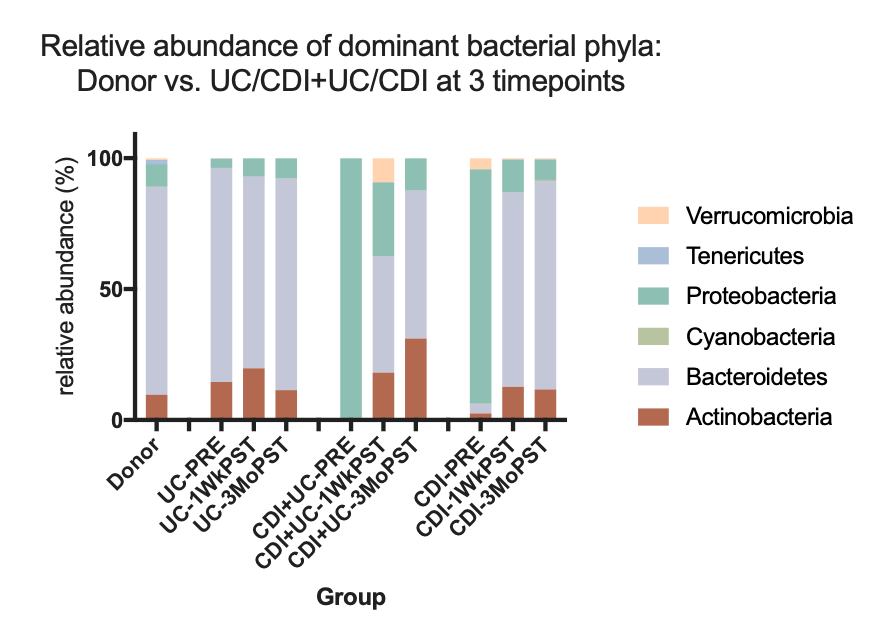

##### CDI-PRE and CDI+UC-PRE very similar, and they converge on the donor community composition after FMT. UC-PRE microbiome looks very similar to the donor community, so UC microbiomes show little change in response to FMT

## `alpha-rarefaction.qza` allows estimation of "sufficient" sampling depth to capture most bacterial taxa in a sample

In [ ]:
!qiime diversity alpha-rarefaction \
  --i-table data/table-excl-mitochloro.qza \
  --i-phylogeny data/rooted-tree.qza \
  --p-max-depth 43804 \
  --m-metadata-file scripts/mapping.txt \
  --o-visualization analyses/alpha-rarefaction.qzv \
  --verbose

!mkdir -p analyses/excl-mitochloro-corediv-43804/export/

>**`alpha-rarefaction.qzv` by Faith's PD**  
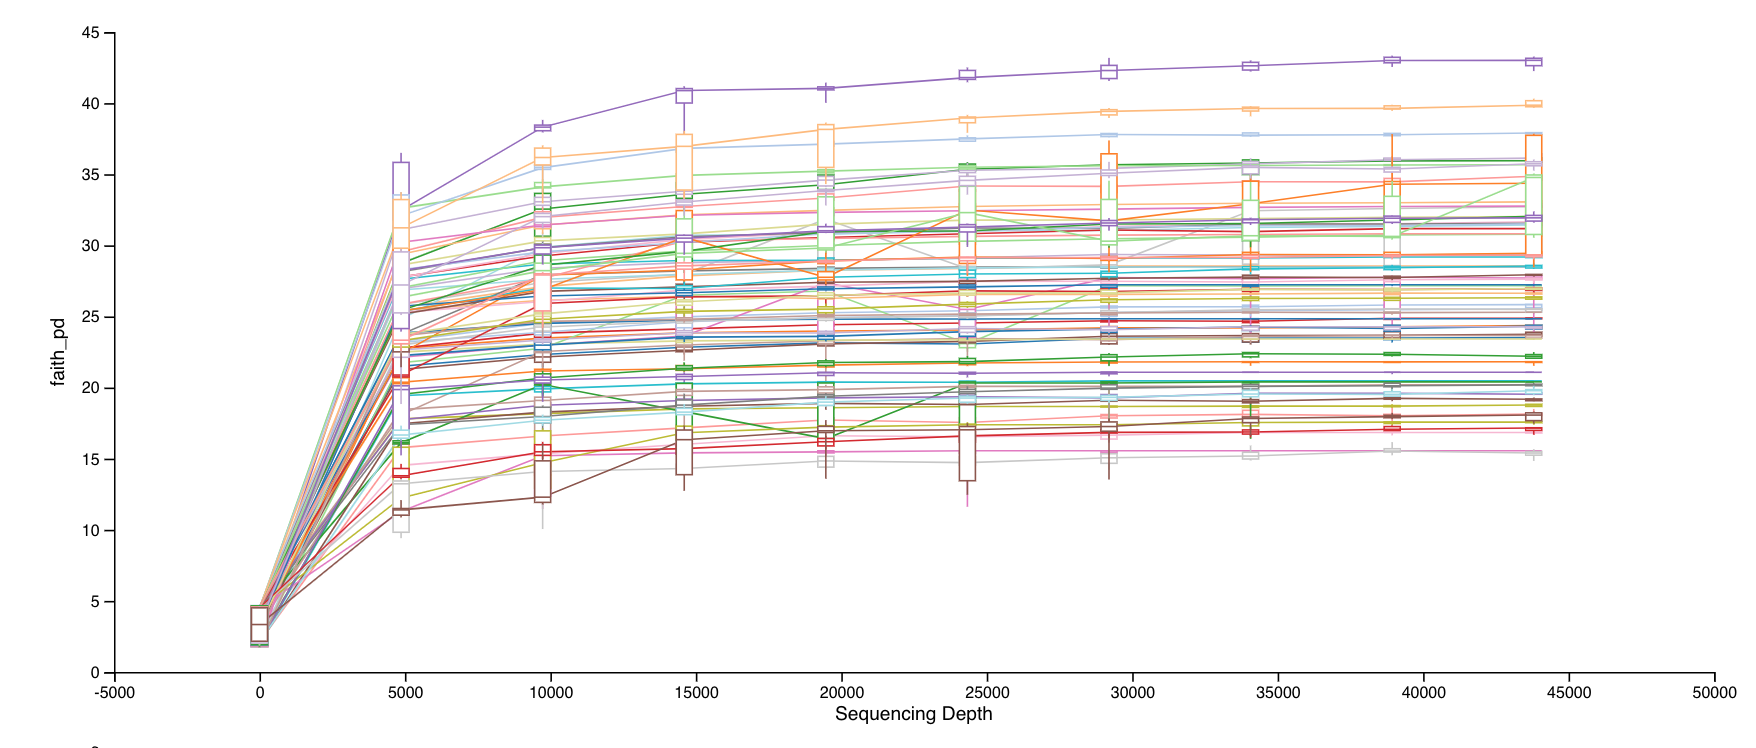
Demonstrates sufficient sampling depth. Most ASVs captured at ~20000,  plateau by sampling depth of 43804 indicates sufficient depth for confident diversity analysis. Unlikely that we are missing significant, abundance ASVs.

## exporting PCoA results for visualization inside Jupyter or in RStudio, parsing output ordination text files for coordinates and PC values

In [2]:
!qiime tools export --input-path analyses/excl-mitochloro-corediv-43804/bray_curtis_pcoa_results.qza \
        --output-path analyses/excl-mitochloro-corediv-43804/export/bray_curtis_pcoa_results
!sed '1,9d' analyses/excl-mitochloro-corediv-43804/export/bray_curtis_pcoa_results/ordination.txt | head -n 8 \
    > analyses/excl-mitochloro-corediv-43804/export/bray_curtis_pcoa_results/coordinates.txt
!head -n 5 analyses/excl-mitochloro-corediv-43804/export/bray_curtis_pcoa_results/ordination.txt | tail -n 1 \
        > analyses/excl-mitochloro-corediv-43804/export/bray_curtis_pcoa_results/pc_values.txt

!qiime tools export --input-path analyses/excl-mitochloro-corediv-43804/weighted_unifrac_pcoa_results.qza \
        --output-path analyses/excl-mitochloro-corediv-43804/export/weighted_unifrac_pcoa_results
!sed '1,9d' analyses/excl-mitochloro-corediv-43804/export/weighted_unifrac_pcoa_results/ordination.txt | head -n 8 \
        >  analyses/excl-mitochloro-corediv-43804/export/weighted_unifrac_pcoa_results/coordinates.txt
!head -n 5 analyses/excl-mitochloro-corediv-43804/export/weighted_unifrac_pcoa_results/ordination.txt | tail -n 1 \
        > analyses/excl-mitochloro-corediv-43804/export/weighted_unifrac_pcoa_results/pc_values.txt

!qiime tools export --input-path analyses/excl-mitochloro-corediv-43804/unweighted_unifrac_pcoa_results.qza \
        --output-path analyses/excl-mitochloro-corediv-43804/export/unweighted_unifrac_pcoa_results
!sed '1,9d' analyses/excl-mitochloro-corediv-43804/export/unweighted_unifrac_pcoa_results/ordination.txt | head -n 8 \
        > analyses/excl-mitochloro-corediv-43804/export/unweighted_unifrac_pcoa_results/coordinates.txt
!head -n 5 analyses/excl-mitochloro-corediv-43804/export/unweighted_unifrac_pcoa_results/ordination.txt | tail -n 1 \
        > analyses/excl-mitochloro-corediv-43804/export/unweighted_unifrac_pcoa_results/pc_values.txt

Exported analyses/excl-mitochloro-corediv-43804/bray_curtis_pcoa_results.qza as OrdinationDirectoryFormat to directory analyses/excl-mitochloro-corediv-43804/export/bray_curtis_pcoa_results
Exported analyses/excl-mitochloro-corediv-43804/weighted_unifrac_pcoa_results.qza as OrdinationDirectoryFormat to directory analyses/excl-mitochloro-corediv-43804/export/weighted_unifrac_pcoa_results
Exported analyses/excl-mitochloro-corediv-43804/unweighted_unifrac_pcoa_results.qza as OrdinationDirectoryFormat to directory analyses/excl-mitochloro-corediv-43804/export/unweighted_unifrac_pcoa_results
sed: stdout: Broken pipe


## Analysis of Alpha Diversity Metrics
Statistical analysis: Kruskal-Wallis pairwise comparison between groups

In [3]:
!qiime diversity alpha-group-significance \
    --i-alpha-diversity analyses/excl-mitochloro-corediv-43804/shannon_vector.qza \
    --m-metadata-file scripts/mapping.txt \
    --o-visualization analyses/excl-mitochloro-corediv-43804/shannon_vector.qzv

!qiime diversity alpha-group-significance \
    --i-alpha-diversity analyses/excl-mitochloro-corediv-43804/faith_pd_vector.qza \
    --m-metadata-file scripts/mapping.txt \
    --o-visualization analyses/excl-mitochloro-corediv-43804/faith_pd_vector.qzv

Saved Visualization to: analyses/excl-mitochloro-corediv-43804/shannon_vector.qzv
Saved Visualization to: analyses/excl-mitochloro-corediv-43804/faith_pd_vector.qzv


#### output: `shannon_vector.qzv` 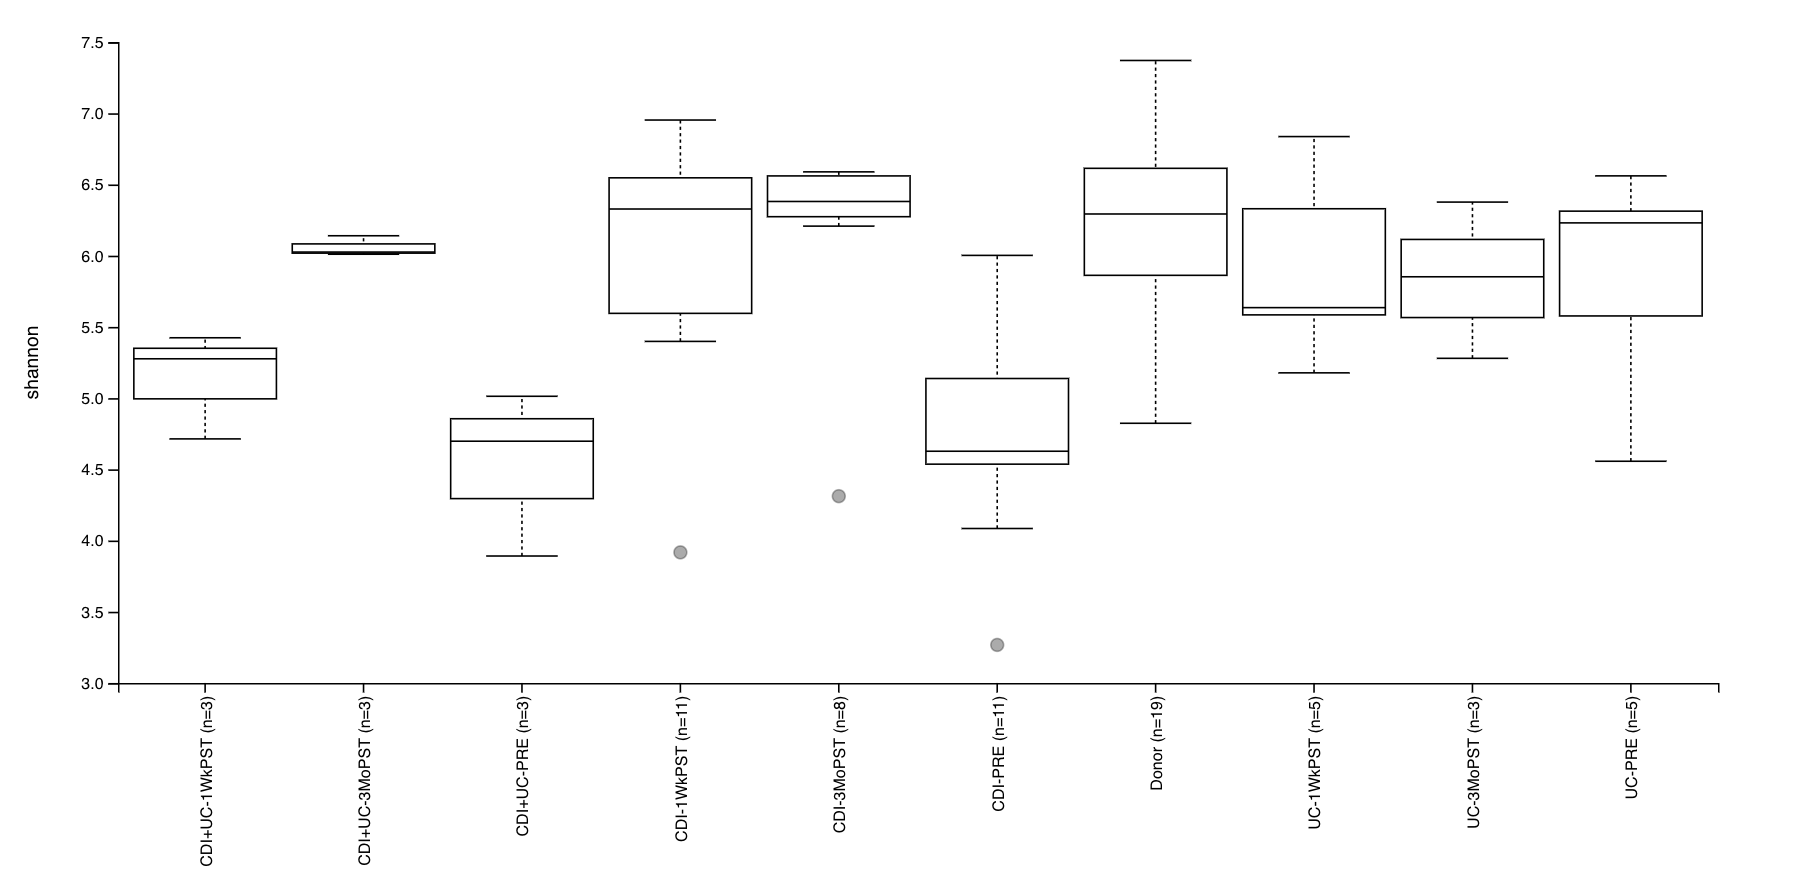

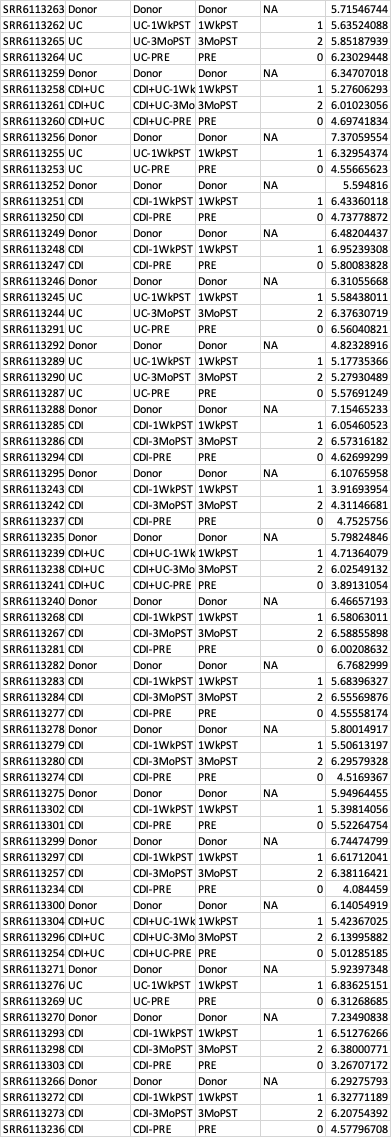

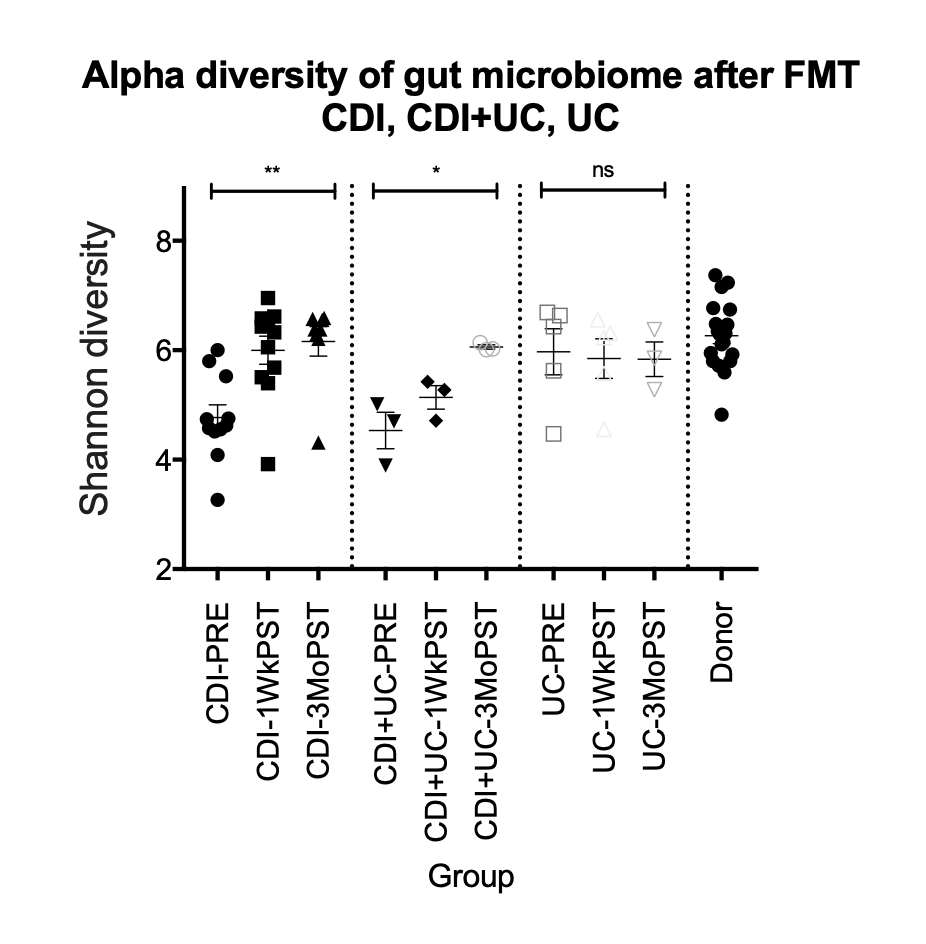

## Analysis of Beta Diversity Metrics by PERMANOVA  
Bray-Curtis (no incorporation of phylogeny/branch length information), Unweighted UniFrac (incorporates phylogeny, does not weight by relative abundance), and Weighted UniFrac. Used default of 999 permutations.

In [13]:
!qiime diversity beta-group-significance \
  --i-distance-matrix analyses/excl-mitochloro-corediv-43804/bray_curtis_distance_matrix.qza  \
  --m-metadata-file scripts/mapping.txt \
  --m-metadata-column "Group" \
  --p-method permanova  \
  --p-pairwise \
  --o-visualization analyses/excl-mitochloro-corediv-43804/bray_curtis_permanova.qzv

!qiime diversity beta-group-significance \
  --i-distance-matrix analyses/excl-mitochloro-corediv-43804/weighted_unifrac_distance_matrix.qza  \
  --m-metadata-file scripts/mapping.txt \
  --m-metadata-column "Group" \
  --p-method permanova  \
  --p-pairwise \
  --o-visualization analyses/excl-mitochloro-corediv-43804/weighted_unifrac_permanova.qzv

!qiime diversity beta-group-significance \
  --i-distance-matrix analyses/excl-mitochloro-corediv-43804/unweighted_unifrac_distance_matrix.qza  \
  --m-metadata-file scripts/mapping.txt \
  --m-metadata-column "Group" \
  --p-method permanova  \
  --p-pairwise \
  --o-visualization analyses/excl-mitochloro-corediv-43804/unweighted_unifrac_permanova.qzv

Saved Visualization to: analyses/excl-mitochloro-corediv-43804/bray_curtis_permanova.qzv
Saved Visualization to: analyses/excl-mitochloro-corediv-43804/weighted_unifrac_permanova.qzv
Saved Visualization to: analyses/excl-mitochloro-corediv-43804/unweighted_unifrac_permanova.qzv


> #### Weighted UniFrac
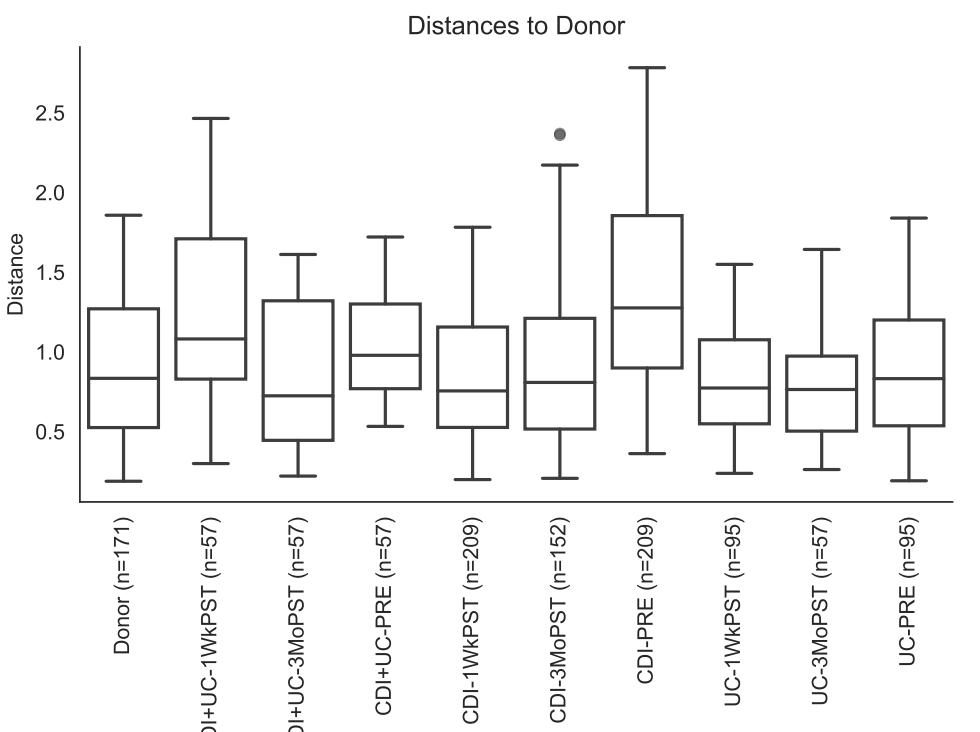

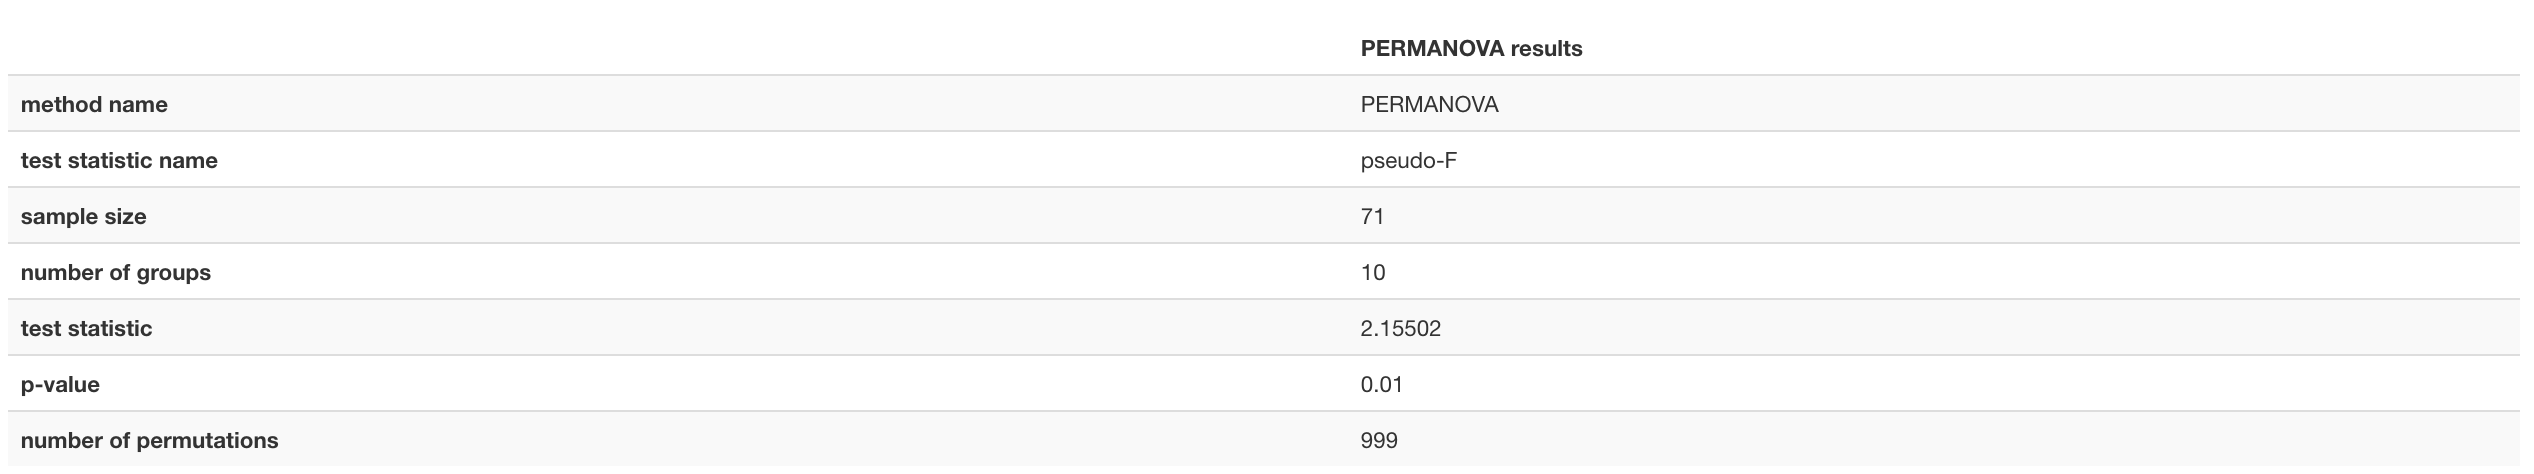

  
    
####  Issue:  <span style="color:red">PERMANOVA was significant (p=0.01), but pairwise comparisons between CDI-PRE and post-FMT were not as significant as expected. I wonder if that is because of the many different donors. While an FMT did rescue the gut microbiome from dysbiosis, it may not have converged on the same structure because of different donor samples. </span>

## Embedded Emperor Plots

Unfortunately, I did not end up getting this to work to the extend that I need it to. I can import the plot, but I cannot get the GUI to recognize my metadatafile, and thus I cannot color any of the points according to their metadata. Without this functionality, the embedded Emperor plot is useless. 

In [5]:
import pandas as pd, numpy as np
from emperor import Emperor, nbinstall
from skbio import OrdinationResults

nbinstall()

def load_mf(fn, index='#SampleID'):
    _df = pd.read_csv(fn, sep="\t", dtype=str, keep_default_na=False, na_values=[])
    _df.set_index(index, inplace=True)
    return _df

mf = load_mf('scripts/emperor_map.txt')
res = OrdinationResults.read('analyses/excl-mitochloro-corediv-43804/export/weighted_unifrac_pcoa_results/ordination.txt')

viz = Emperor(res, mf, remote=False)
viz

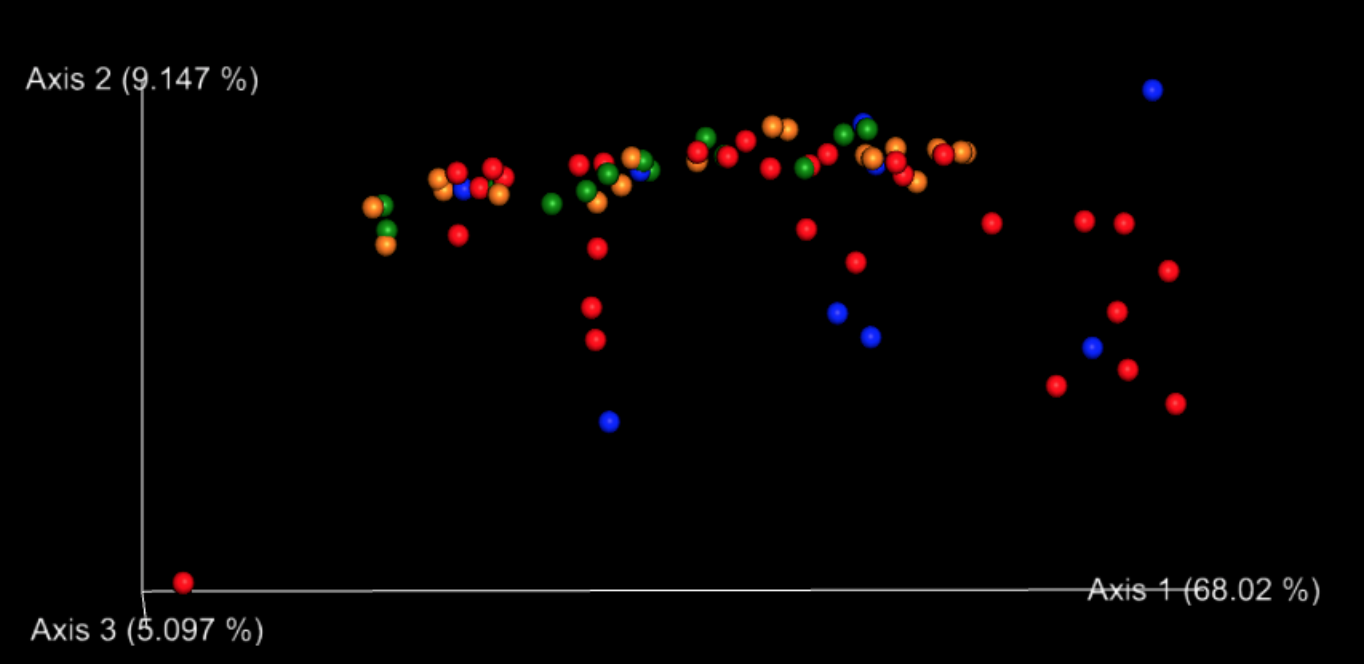

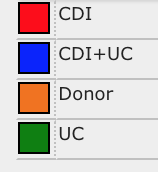

## for more interactive visualization, load analyses/excl-mitochloro-corediv-43804/weighted-unifrac-emperor.qza in Qiime2 viewer (www.view.qiime2.org)



### 9) Differential Abundance Testing with Gneiss

I did not get to the point where I am comfortable interpreting the output from Gneiss, so moving forward I will likely export my ASV tables to R for use with DeSEQ2.

In [6]:
!qiime gneiss correlation-clustering \
  --i-table data/table-excl-mitochloro.qza \
  --o-clustering analyses/hierarchy.qza \
  --verbose

Saved Hierarchy to: analyses/hierarchy.qza


In [7]:
!qiime gneiss ilr-hierarchical \
  --i-table data/table-excl-mitochloro.qza \
  --i-tree analyses/hierarchy.qza \
  --o-balances analyses/balances.qza \
  --verbose

/anaconda3/envs/qiime2-2018.8/lib/python3.5/site-packages/gneiss-0.4.4-py3.5.egg/gneiss/util.py:245: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
Saved FeatureTable[Balance] to: analyses/balances.qza


   Added "CDI-pre-FMT" field to `scripts/mapping.txt` to group all samples that are positive for CDI and before FMT. 

In [26]:
!qiime gneiss ols-regression \
  --p-formula "CDI_pre_FMT" \
  --i-table analyses/balances.qza \
  --i-tree analyses/hierarchy.qza \
  --m-metadata-file scripts/mapping.txt \
  --o-visualization analyses/CDI_status_regression_summary.qzv \
  --verbose

Saved Visualization to: analyses/CDI_status_regression_summary.qzv


In [27]:
!qiime gneiss dendrogram-heatmap \
  --i-table data/table-excl-mitochloro.qza \
  --i-tree analyses/hierarchy.qza \
  --m-metadata-file scripts/mapping.txt \
  --m-metadata-column Group \
  --p-color-map seismic \
  --o-visualization analyses/CDI_status_heatmap.qzv \
  --verbose

/anaconda3/envs/qiime2-2018.8/lib/python3.5/site-packages/gneiss-0.4.4-py3.5.egg/gneiss/util.py:245: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
Saved Visualization to: analyses/CDI_status_heatmap.qzv


## Making differential abundance summaries for phylum, order

Samples grouped on metadata column CDI_pre_FMT, which groups all CDI-positive patients together pre-FMT.

In [28]:
!qiime gneiss balance-taxonomy \
  --i-table data/table-excl-mitochloro.qza \
  --i-tree analyses/hierarchy.qza \
  --i-taxonomy analyses/silva-taxonomy.qza \
  --p-taxa-level 2 \
  --p-balance-name 'y0' \
  --m-metadata-file scripts/mapping.txt \
  --m-metadata-column CDI_pre_FMT \
  --o-visualization analyses/CDI_status_y0_taxa_L2_summary.qzv \
  --verbose

!qiime gneiss balance-taxonomy \
  --i-table data/table-excl-mitochloro.qza \
  --i-tree analyses/hierarchy.qza \
  --i-taxonomy analyses/silva-taxonomy.qza \
  --p-taxa-level 4 \
  --p-balance-name 'y0' \
  --m-metadata-file scripts/mapping.txt \
  --m-metadata-column CDI_pre_FMT \
  --o-visualization analyses/CDI_status_y0_taxa_L4_summary.qzv \
  --verbose


/anaconda3/envs/qiime2-2018.8/lib/python3.5/site-packages/gneiss-0.4.4-py3.5.egg/gneiss/util.py:245: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
Saved Visualization to: analyses/CDI_status_y0_taxa_L2_summary.qzv
/anaconda3/envs/qiime2-2018.8/lib/python3.5/site-packages/gneiss-0.4.4-py3.5.egg/gneiss/util.py:245: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
Saved Visualization to: analyses/CDI_status_y0_taxa_L4_summary.qzv


> ### Differential abundance plot (taxa level 4/family),  from `CDI_status_y0_taxa_L4_summary.qzv`
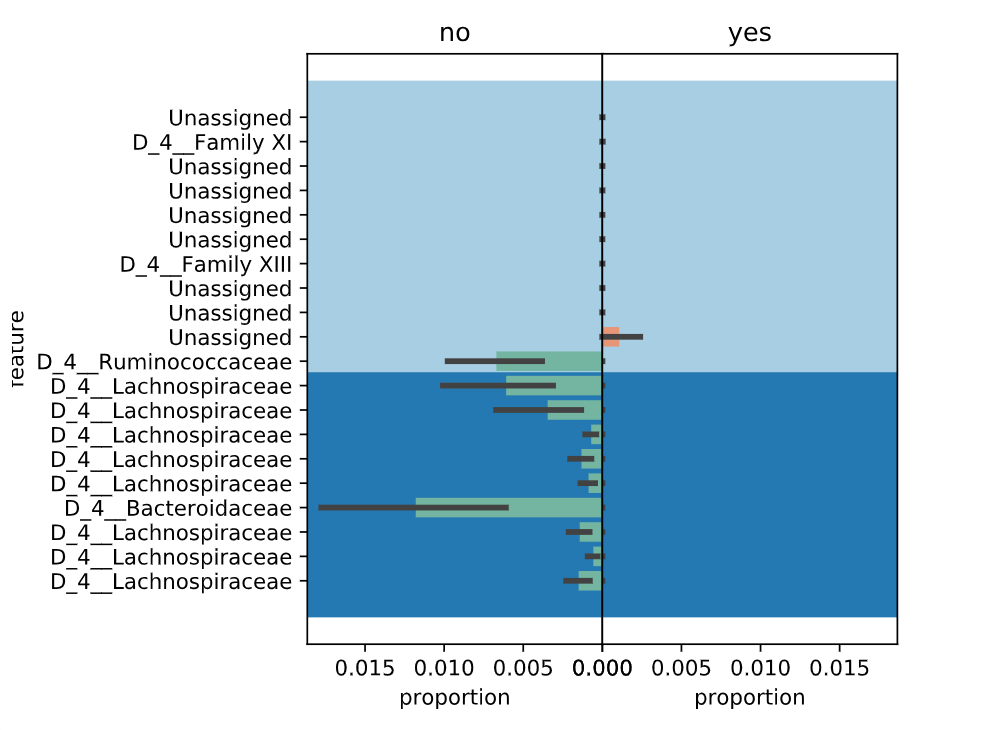

Interestingly, it seems like Lachnospiraceae are enriched in individuals who are CDI-negative. Lachnospiraceae is a family in the order Clostridiales, which also contains the _C. diff_'s family, Clostridiaceae.

### Heatmap showing patterns of change between groups 
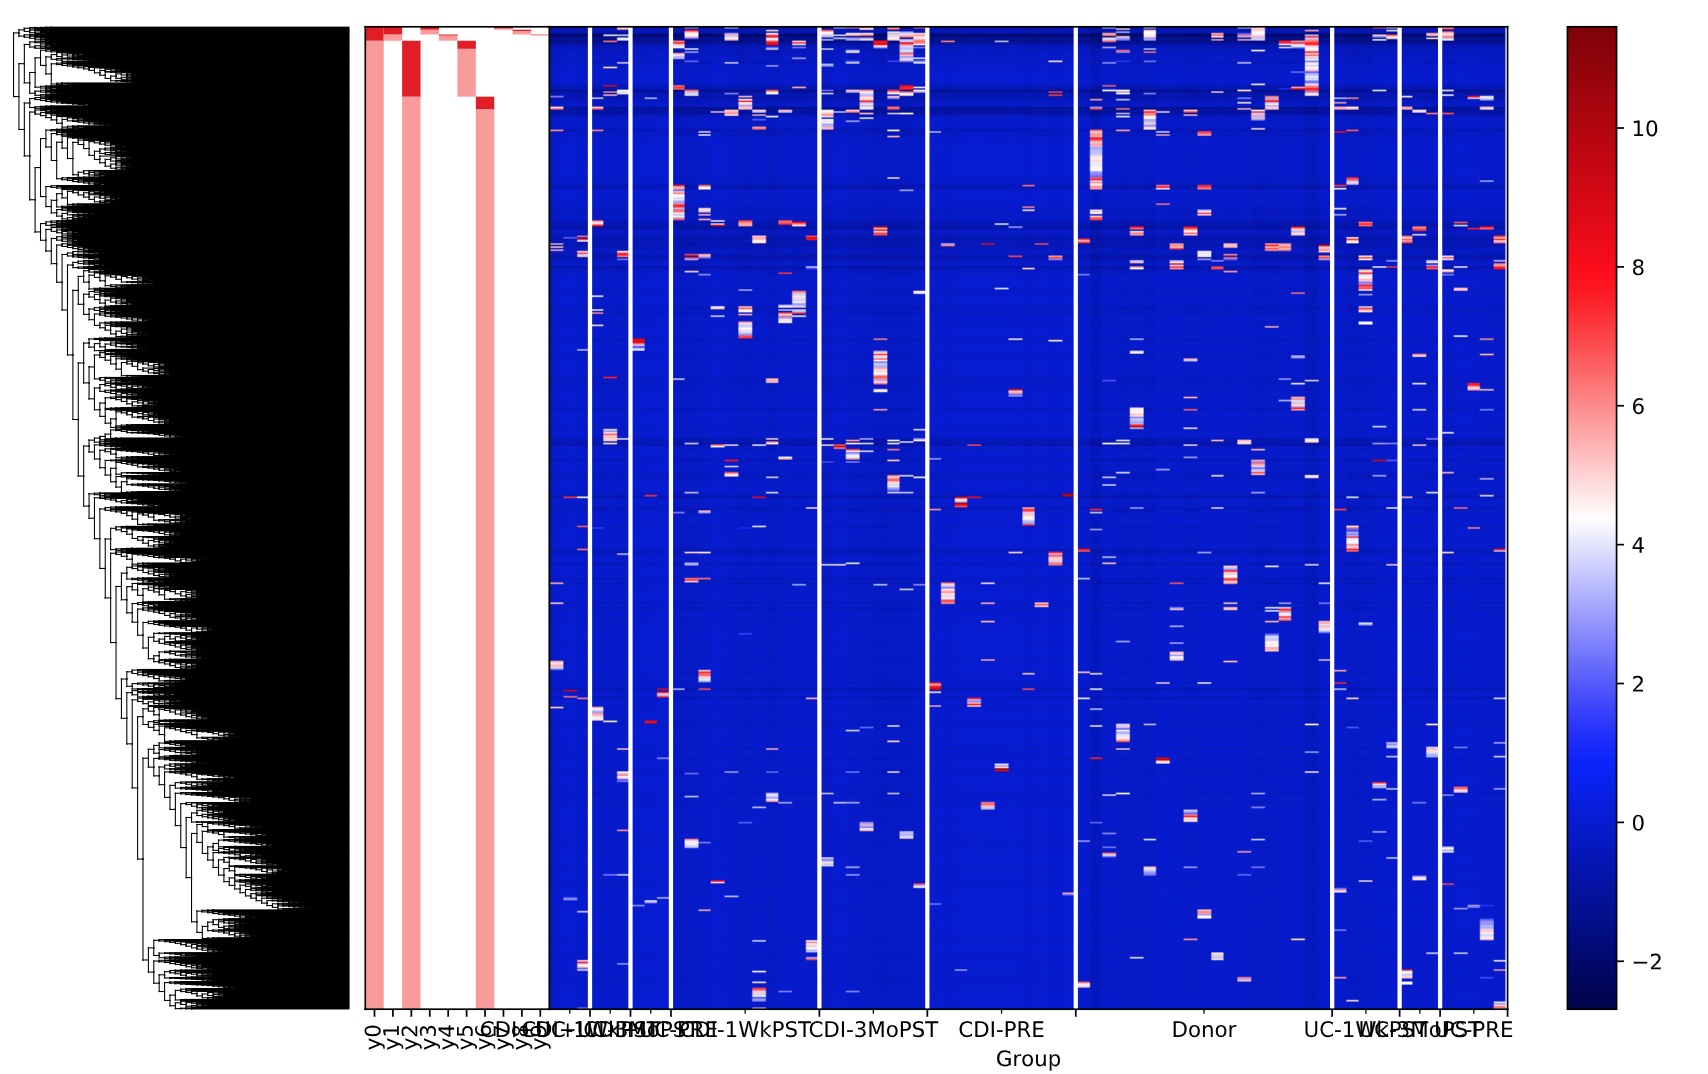

This feels unresolved. I wish I had more time to try this a few more times.

### 10) Functional profiling of microbiome with PICRUSt
PICRUSt uses 16S count data to estimate the gene families contributed by each member of the microbiome.

First, download the PICRUSt reference phylogeny and tree

In [21]:
!wget http://kronos.pharmacology.dal.ca/public_files/tutorial_datasets/picrust2_tutorial_files/reference.fna.qza

!wget http://kronos.pharmacology.dal.ca/public_files/tutorial_datasets/picrust2_tutorial_files/reference.tre.qza 

--2018-12-06 08:08:55--  http://kronos.pharmacology.dal.ca/public_files/tutorial_datasets/picrust2_tutorial_files/reference.fna.qza
Resolving kronos.pharmacology.dal.ca... 129.173.80.34
Connecting to kronos.pharmacology.dal.ca|129.173.80.34|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4408600 (4.2M)
Saving to: 'reference.fna.qza'

reference.fna.qza   100%[===================>]   4.20M  1.04MB/s    in 4.4s    

2018-12-06 08:08:59 (981 KB/s) - 'reference.fna.qza' saved [4408600/4408600]

--2018-12-06 08:09:00--  http://kronos.pharmacology.dal.ca/public_files/tutorial_datasets/picrust2_tutorial_files/reference.tre.qza
Resolving kronos.pharmacology.dal.ca... 129.173.80.34
Connecting to kronos.pharmacology.dal.ca|129.173.80.34|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 191187 (187K)
Saving to: 'reference.tre.qza'

reference.tre.qza   100%[===================>] 186.71K   440KB/s    in 0.4s    

2018-12-06 08:09:00 (440 KB/s) - 'refer

In [23]:
!qiime fragment-insertion sepp \
    --i-representative-sequences data/rep-seqs.qza \
    --p-threads 1 \
    --i-reference-alignment reference.fna.qza \
    --i-reference-phylogeny reference.tre.qza \
    --output-dir data/frag-tree/

Saved Phylogeny[Rooted] to: data/frag-tree/tree.qza
Saved Placements to: data/frag-tree/placements.qza


In [24]:
!qiime picrust2 custom-tree-pipeline --i-table data/table-excl-mitochloro.qza \
                                    --i-tree data/frag-tree/tree.qza \
                                    --output-dir analyses/q2-picrust2_output \
                                    --p-threads 1 --p-hsp-method mp \
                                    --p-max-nsti 2

Error running this command:
hsp.py -i EC -t /tmp/tmp0uyn3paz/placed_seqs.tre -p 1 -o /tmp/tmp0uyn3paz/picrust2_out/EC_predicted -m mp


In [25]:
!echo $TMPDIR

/
